<a href="https://colab.research.google.com/github/aricahyasaputra/machine-learning-course-assigment/blob/main/Minggu%205%20Exploratory%20Data%20Analysis%20(EDA)/Tugas_Minggu_5_Exploratory_Data_Analysis_(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Nama : Ari Cahya Saputra

NIM : 1103190093

Kelas : TK-42-PIL1


#PCA example with Iris Data-set

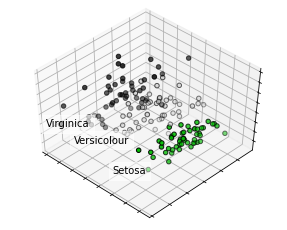

In [1]:
# Code source: Gaël Varoquaux
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 0].mean(),
        X[y == label, 1].mean() + 1.5,
        X[y == label, 2].mean(),
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

#Comparison of LDA and PCA 2D projection of Iris dataset

The Iris dataset represents 3 kind of Iris flowers (Setosa, Versicolour and Virginica) with 4 attributes: sepal length, sepal width, petal length and petal width.

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

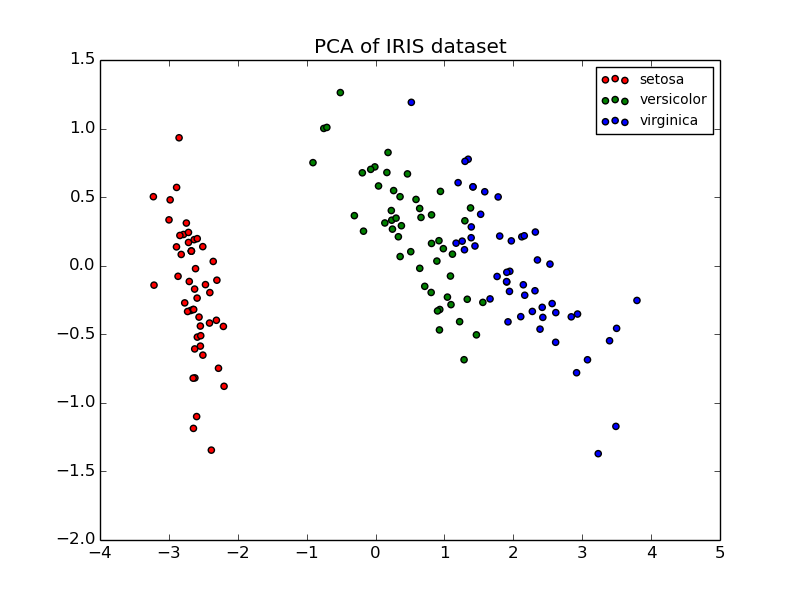
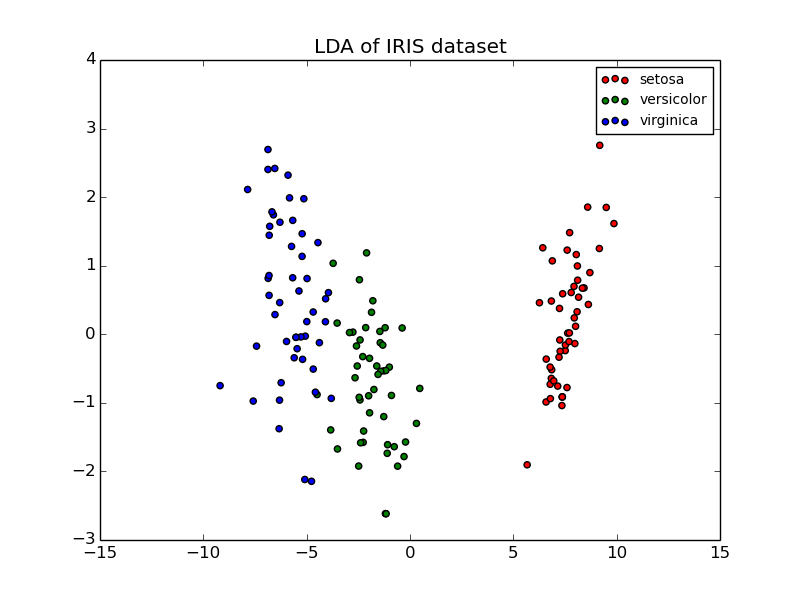

Automatically created module for IPython interactive environment
explained variance ratio (first two components): [0.92461872 0.05306648]


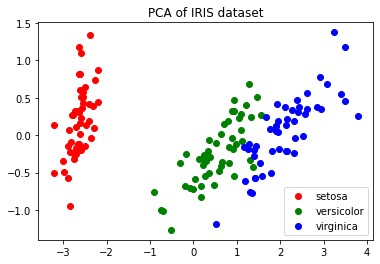

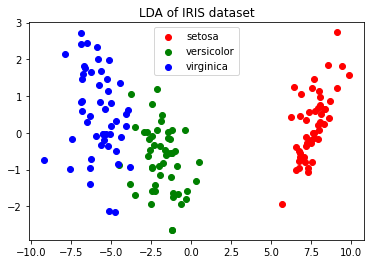

In [4]:
print(__doc__)

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of IRIS dataset')

plt.show()

#Clustering text documents using k-means (SVD)

This is an example showing how the scikit-learn can be used to cluster documents by topics using a bag-of-words approach. This example uses a scipy.sparse matrix to store the features instead of standard numpy arrays.

Two feature extraction methods can be used in this example:


*   TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.
*   HashingVectorizer hashes word occurrences to a fixed dimensional space, possibly with collisions. The word count vectors are then normalized to each have l2-norm equal to one (projected to the euclidean unit-ball) which seems to be important for k-means to work in high dimensional space.
HashingVectorizer does not provide IDF weighting as this is a stateless model (the fit method does nothing). When IDF weighting is needed it can be added by pipelining its output to a TfidfTransformer instance.

Two algorithms are demoed: ordinary k-means and its more scalable cousin minibatch k-means.

Additionally, latent semantic analysis can also be used to reduce dimensionality and discover latent patterns in the data.

It can be noted that k-means (and minibatch k-means) are very sensitive to feature scaling and that in this case the IDF weighting helps improve the quality of the clustering by quite a lot as measured against the “ground truth” provided by the class label assignments of the 20 newsgroups dataset.

This improvement is not visible in the Silhouette Coefficient which is small for both as this measure seem to suffer from the phenomenon called “Concentration of Measure” or “Curse of Dimensionality” for high dimensional datasets such as text data. Other measures such as V-measure and Adjusted Rand Index are information theoretic based evaluation scores: as they are only based on cluster assignments rather than distances, hence not affected by the curse of dimensionality.

Note: as k-means is optimizing a non-convex objective function, it will likely end up in a local optimum. Several runs with independent random init might be necessary to get a good convergence.

In [5]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Lars Buitinck
# License: BSD 3 clause

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time

import numpy as np


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

# parse commandline arguments
op = OptionParser()
op.add_option(
    "--lsa",
    dest="n_components",
    type="int",
    help="Preprocess documents with latent semantic analysis.",
)
op.add_option(
    "--no-minibatch",
    action="store_false",
    dest="minibatch",
    default=True,
    help="Use ordinary k-means algorithm (in batch mode).",
)
op.add_option(
    "--no-idf",
    action="store_false",
    dest="use_idf",
    default=True,
    help="Disable Inverse Document Frequency feature weighting.",
)
op.add_option(
    "--use-hashing",
    action="store_true",
    default=False,
    help="Use a hashing feature vectorizer",
)
op.add_option(
    "--n-features",
    type=int,
    default=10000,
    help="Maximum number of features (dimensions) to extract from text.",
)
op.add_option(
    "--verbose",
    action="store_true",
    dest="verbose",
    default=False,
    help="Print progress reports inside k-means algorithm.",
)

print(__doc__)
op.print_help()
print()


def is_interactive():
    return not hasattr(sys.modules["__main__"], "__file__")


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)


# #############################################################################
# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(
    subset="all", categories=categories, shuffle=True, random_state=42
)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    if opts.use_idf:
        # Perform an IDF normalization on the output of HashingVectorizer
        hasher = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm=None,
        )
        vectorizer = make_pipeline(hasher, TfidfTransformer())
    else:
        vectorizer = HashingVectorizer(
            n_features=opts.n_features,
            stop_words="english",
            alternate_sign=False,
            norm="l2",
        )
else:
    vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=opts.n_features,
        min_df=2,
        stop_words="english",
        use_idf=opts.use_idf,
    )
X = vectorizer.fit_transform(dataset.data)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

if opts.n_components:
    print("Performing dimensionality reduction using LSA")
    t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(opts.n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    print("done in %fs" % (time() - t0))

    explained_variance = svd.explained_variance_ratio_.sum()
    print(
        "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
    )

    print()


# #############################################################################
# Do the actual clustering

if opts.minibatch:
    km = MiniBatchKMeans(
        n_clusters=true_k,
        init="k-means++",
        n_init=1,
        init_size=1000,
        batch_size=1000,
        verbose=opts.verbose,
    )
else:
    km = KMeans(
        n_clusters=true_k,
        init="k-means++",
        max_iter=100,
        n_init=1,
        verbose=opts.verbose,
    )

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print(
    "Silhouette Coefficient: %0.3f"
    % metrics.silhouette_score(X, km.labels_, sample_size=1000)
)

print()


if not opts.use_hashing:
    print("Top terms per cluster:")

    if opts.n_components:
        original_space_centroids = svd.inverse_transform(km.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms = vectorizer.get_feature_names_out()
    for i in range(true_k):
        print("Cluster %d:" % i, end="")
        for ind in order_centroids[i, :10]:
            print(" %s" % terms[ind], end="")
        print()

2022-04-11 14:28:13,354 INFO Downloading 20news dataset. This may take a few minutes.
2022-04-11 14:28:13,363 INFO Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --lsa=N_COMPONENTS    Preprocess documents with latent semantic analysis.
  --no-minibatch        Use ordinary k-means algorithm (in batch mode).
  --no-idf              Disable Inverse Document Frequency feature weighting.
  --use-hashing         Use a hashing feature vectorizer
  --n-features=N_FEATURES
                        Maximum number of features (dimensions) to extract
                        from text.
  --verbose             Print progress reports inside k-means algorithm.

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
3387 documents
4 categories

Extracting features from the training dataset using a sparse vectorizer
done in 0.995543s
n_samples: 3387, n_features: 10000

Clustering sparse data with MiniBatchKMeans(batch_size=1000, init_si